# Predizone del prezzo dei voli da Marzo a Giugno

**Progetto di Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Balzoni Margherita  
margherita.balzoni@studio.unibo.it

## Caricamento Librerie

Caricamento delle librerie necessarie per effettuare le operazioni sui dati.

- **NumPy** per creare e operare su array a N dimensioni
- **pandas** per caricare e manipolare dati tabulati
- **matplotlib** per creare grafici


In [3002]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

## Descrizione del problema

Negli ultimi anni, il settore dei voli aerei ha visto un aumento significativo della domanda, con un numero crescente di passeggeri che viaggiano per motivi di lavoro, turismo e altre necessità personali. Con l'incremento del traffico aereo, prevedere i prezzi dei voli è diventato un'area di interesse cruciale per le compagnie aeree, gli agenti di viaggio e i consumatori, poiché i prezzi dei biglietti possono variare notevolmente a seconda di diversi fattori.

In questo progetto, l'obiettivo è sviluppare un modello di regressione in grado di prevedere il prezzo dei voli per una determinata tratta durante il periodo primaverile. Questo implica che il modello di previsione del prezzo dei biglietti aerei sarà specifico per questo intervallo temporale e non sarà generalizzabile ai voli prenotati in altri mesi.

## Caricamento dei dati



Il seguente dataset contiene informazioni dettagliate su 10683 voli aerei tra Marzo e Giugno 2019.

In [3003]:
#modulo che fornisce le funzioni per la manipolazione dei percorsi dei file
import os.path

file = "flight_data.csv"
if not os.path.exists(file):
    print("Missing dataset, retrieve it from kaggle")

dataset= pd.read_csv(file, index_col=0)


## Significato delle Colonne

- **Airline:**  Nome della compagia aerea.
- **Date_of_Journey:** Indica la data di partenza del volo.
- **Source:** Città di partenza.
- **Destination:** Città di destinazione.
- **Route:** Lista degli aeroporti in cui verrà fatto scalo durante il viaggio 
- **Total_Stops:** Numero di scali previsti.
- **Dep_Time:** Orario di partenza del volo
- **Arrival_Time:** Orario di arrivo previsto
- **Duration:** Durata complessiva del volo
- **Additional_Info:** Informazioni aggiuntive riguardo al volo
- **Price:** Prezzo del biglietto



In [3004]:
dataset.head()

,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
Airline,,,,,,,,,,
IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3005]:
dataset.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 10683 entries, IndiGo to Air India
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date_of_Journey  10683 non-null  object
 1   Source           10683 non-null  object
 2   Destination      10683 non-null  object
 3   Route            10682 non-null  object
 4   Dep_Time         10683 non-null  object
 5   Arrival_Time     10683 non-null  object
 6   Duration         10683 non-null  object
 7   Total_Stops      10682 non-null  object
 8   Additional_Info  10683 non-null  object
 9   Price            10683 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 6.2 MB


In [3006]:
dataset.reset_index(inplace=True)
dataset.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 6.2 MB


In [3007]:
dataset.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


Il prezzo del biglietto all'interno del dataset è espresso in Rupie indiane, per comodità e per una maggiore comprensione dei dati, procederemo a convertirlo in euro.

In [3008]:
tasso_di_cambio = 0.011  # 1 INR = 0.011 EUR
dataset['Price'] = round(dataset['Price'] * tasso_di_cambio, 2)

In [3009]:
dataset.describe()

,Price
count,10683.000000
mean,99.957207
std,50.724979
min,19.350000
25%,58.050000
50%,92.090000
75%,136.100000
max,874.630000


Da questi dati possiamo vedere come il prezzo più basso di un biglietto sia 19.35€, il prezzo più alto 874.63€ e che la media si aggiri attorno ai 100€.


## Preporcessing dei dati

### aggiunta di variabili
Ricaviamo dalla feature **Date_of_Journey** altre  features che ci saranno utili per la nostra previsione ovvero **Day**, **Month** e **Year**. Aggiungiamo inoltre la feature che ci permette di capire il giorno della settimana in cui è partito il volo per poter capire se esso incide con l'aumento del costo del biglietto.

In [3010]:
dataset["Date_of_Journey"] = pd.to_datetime(dataset["Date_of_Journey"])

dataset["Day"] = dataset.Date_of_Journey.dt.day
dataset["Month"] = dataset.Date_of_Journey.dt.month
dataset["Year"] = dataset.Date_of_Journey.dt.year

dataset["Day_of_Week"] = dataset.Date_of_Journey.dt.weekday

dataset = dataset.drop("Date_of_Journey", axis = 1)

In [3011]:
dataset["Year"].value_counts()


Year
2019    10683
Name: count, dtype: int64

come possiamo notare utilizzando al funzione value_counts() il dataset presenta solo voli effettuati nel 2019 di conseguenza la features può essere rimossa

In [3012]:
dataset = dataset.drop("Year", axis = 1)

In [3013]:
dataset["Month"].value_counts()

Month
5    3466
6    3414
3    2724
4    1079
Name: count, dtype: int64

In questo caso i mesi presenti nel dataset sono solo quelli che vanno da Marzo a Giugno. Questo implica che il modello di previsione del prezzo dei biglietti aerei sarà specifico per questo intervallo temporale e non sarà generalizzabile ai voli prenotati in altri mesi.

Per migliorare l'interpretabilità dei dati, vengono sostituiti i valori ottenuti per le feature **Month** e **Day_of_Week** con i nomi dei mesi  e i giorni della settimana corrispondenti

In [3014]:
month = {
    3:'Mar',
    4:'Apr',
    5:'May',
    6:'June',
}

day = {
    0:'Mon',
    1:'Tue',
    2:'Wed',
    3:'Thu',
    4:'Fri',
    5:'Sat',
    6:'Sun'
}

dataset["Month"] = dataset.Month.map(month).astype("category")
dataset["Day_of_Week"] = dataset.Day_of_Week.map(day).astype("category")

Anche per quanto riguarda le features **Dep_Time** , **Arrival_Time** e **Duration** è necessario estrarre due nuove variabaili ciascuna per poter ricavare le ore e i minuti

In [3015]:
dataset["Dep_Time"] = pd.to_datetime(dataset["Dep_Time"])
dataset["Arrival_Time"] = pd.to_datetime(dataset["Arrival_Time"])

dataset["Dep_hour"] = dataset.Dep_Time.dt.hour
dataset["Dep_min"] = dataset.Dep_Time.dt.minute

dataset["Arrival_hour"] = dataset.Arrival_Time.dt.hour
dataset["Arrival_min"] = dataset.Arrival_Time.dt.minute

dataset = dataset.drop("Dep_Time", axis = 1)
dataset = dataset.drop("Arrival_Time", axis = 1)

La colonna **Duration** contiene stringhe che rappresentano la durata dei voli in formato testuale (come "2h 30m", "1h 45m", "3h", "45m"). Bisogna, quindi, convertire il contenuto della colonna **Duration** in un formato che rappresenti la durata in ore e minuti, in modo da poter eseguire calcoli o analisi temporali più agevolmente.

Prima però è importante gestire i casi in cui la durata non include ore o minuti

In [3016]:

duration = list(dataset['Duration'])

for i in range(len(duration)):
    parts = duration[i].split(' ')
    if len(parts) == 1:
        if 'h' in parts[0]:
            duration[i] = duration[i] + ' 0m'
        else:
            duration[i] = '0h ' + duration[i]
    elif len(parts) == 2:
        if 'h' not in parts[0]:
            duration[i] = '0h ' + duration[i]
        elif 'm' not in parts[1]:
            duration[i] = duration[i] + ' 0m'
        

dataset["Duration"] = duration


In [3017]:
def extract_hours(d):
    return int(d.split(' ')[0][:-1]) 

def extract_minutes(d):
    return int(d.split(' ')[-1][:-1]) 

In [3018]:
dataset['Duration_hour'] = dataset['Duration'].apply(extract_hours)
dataset['Duration_minute'] = dataset['Duration'].apply(extract_minutes)
dataset = dataset.drop("Duration", axis = 1)

Possiamo rimuovere anche la colonna **Additional_Info** perchè risulta essere inutile per le nostre previsioni

In [3019]:
dataset = dataset.drop("Additional_Info", axis = 1)

In [3020]:
dataset.head(10)

,Airline,Source,Destination,Route,Total_Stops,Price,Day,Month,Day_of_Week,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hour,Duration_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,42.87,24,Mar,Sun,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,84.28,1,May,Wed,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,152.70,9,June,Sun,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,68.40,12,May,Sun,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,146.32,1,Mar,Fri,16,50,21,35,4,45
5,SpiceJet,Kolkata,Banglore,CCU → BLR,non-stop,42.60,24,June,Mon,9,0,11,25,2,25
6,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,1 stop,121.96,12,Mar,Tue,18,55,10,25,15,30
7,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,1 stop,244.97,1,Mar,Fri,8,0,5,5,21,5
8,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,1 stop,121.96,12,Mar,Tue,8,55,10,25,25,30
9,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,1 stop,94.88,27,May,Mon,11,25,19,15,7,50


### Valori mancanti

Utilizzando il metodo **isna()** verifichiamo la presenza di valori nulli all'interno del dataset 

In [3072]:
dataset.isna().any()

Total_Stops                        False
Price                              False
Day                                False
Dep_hour                           False
Dep_min                            False
                                   ...  
Airline_Vistara Premium economy    False
Month_Apr                          False
Month_June                         False
Month_Mar                          False
Month_May                          False
Length: 142, dtype: bool

Per capire come gestire i dati mancanti, verifichiamone prima la quantità

In [3022]:
missing_data = dataset.isnull().sum()
print(missing_data)

Airline            0
Source             0
Destination        0
Route              1
Total_Stops        1
Price              0
Day                0
Month              0
Day_of_Week        0
Dep_hour           0
Dep_min            0
Arrival_hour       0
Arrival_min        0
Duration_hour      0
Duration_minute    0
dtype: int64


Poichè i dati mancanti sono solo 2 ( 1 per la colonna delle Rotte e 1 per la colonna che indica il numero degli scali ), possiamo procedere rimuovendoli

In [3023]:
dataset = dataset.dropna()

### Tipi di dato

In [3024]:
dataset.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
Index: 10682 entries, 0 to 10682
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Airline          10682 non-null  object  
 1   Source           10682 non-null  object  
 2   Destination      10682 non-null  object  
 3   Route            10682 non-null  object  
 4   Total_Stops      10682 non-null  object  
 5   Price            10682 non-null  float64 
 6   Day              10682 non-null  int32   
 7   Month            10682 non-null  category
 8   Day_of_Week      10682 non-null  category
 9   Dep_hour         10682 non-null  int32   
 10  Dep_min          10682 non-null  int32   
 11  Arrival_hour     10682 non-null  int32   
 12  Arrival_min      10682 non-null  int32   
 13  Duration_hour    10682 non-null  int64   
 14  Duration_minute  10682 non-null  int64   
dtypes: category(2), float64(1), int32(5), int64(2), object(5)
memory usage: 3.8 MB


Convertiamo  la variabile **Total_Stops** da Object ad intero mappando i valori della variabile (non-stop, 2 stops, 1 stops...) nel corrispondete numero di scali previsti dal volo

In [3025]:
# Mappatura per sostituire "non-stop" con 0
stop_mapping = {'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4}

# Applica la sostituzione e converte in intero
dataset['Total_Stops'] = dataset['Total_Stops'].replace(stop_mapping).astype(int)

Convertiamo le variabili object rimanenti in categorical

In [3026]:
categorical = ["Airline", "Source", "Destination", "Route"]

for col in categorical:
    if col in dataset.columns:
        dataset[col] = dataset[col].astype("category")
        
dataset.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 10682 entries, 0 to 10682
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Airline          10682 non-null  category
 1   Source           10682 non-null  category
 2   Destination      10682 non-null  category
 3   Route            10682 non-null  category
 4   Total_Stops      10682 non-null  int32   
 5   Price            10682 non-null  float64 
 6   Day              10682 non-null  int32   
 7   Month            10682 non-null  category
 8   Day_of_Week      10682 non-null  category
 9   Dep_hour         10682 non-null  int32   
 10  Dep_min          10682 non-null  int32   
 11  Arrival_hour     10682 non-null  int32   
 12  Arrival_min      10682 non-null  int32   
 13  Duration_hour    10682 non-null  int64   
 14  Duration_minute  10682 non-null  int64   
dtypes: category(6), float64(1), int32(6), int64(2)
memory usage: 680.4 KB


Come si può notare dopo le modifiche effettuate il peso in memoria del dataset è diminuito

## Analisi dei dati:

Ora analizzeremo i dati persenti nel dataset prendendo in considerazione le correlazioni tra essi e in particolare con la feature **Price**. 
Le correlazioni presenti verranno messe in evidenza utilizzando una matrice di correlazione:

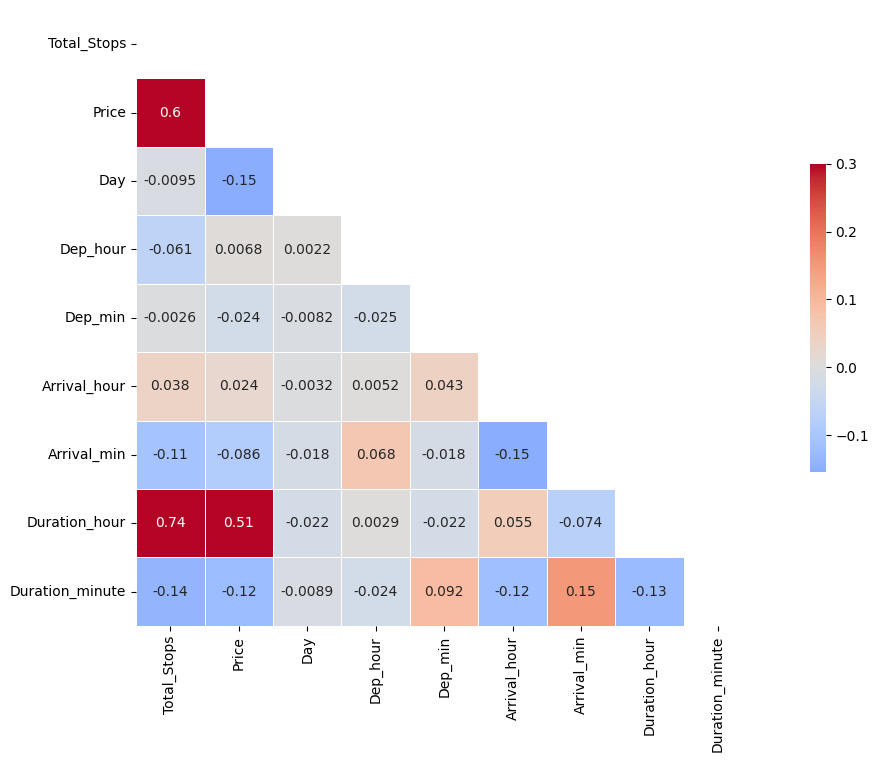

In [3027]:

import seaborn as sns

def var_correlation(dataset):

    numeric_cols = dataset.select_dtypes(include=np.number)
    corr_matrix = numeric_cols.corr()
    f, ax = plt.subplots(figsize=(15, 8))
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=.3, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
     

var_correlation(dataset)

Come possiamo vedere dai risultati ottenuti, non è presente nessun parametro con correlazione forte con la variabile **Price**. Tuttavia, la variabile **Total_stops** presenta una correlazione moderata e positiva (0.61) con **Price**, suggerendo che il numero di scali influisce significativamente sul prezzo del biglietto. La variabile **Duration_hour** ha una correlazione moderata e positiva (0.51) con **Price**, indicando che le ore di durata del volo influenzano anch'esse in modo significativo il prezzo del biglietto. Le variabili **Day** e **Duration_minute** hanno una correlazione leggermente negativa e quindi avranno un leggero effetto negativo sul prezzo del biglietto. Tuttavia, queste ultime due, insieme alle altre correlazioni trovate, sono deboli, il che significa che non avranno un impatto forte.

### Distribuzione del prezzo dei biglietti

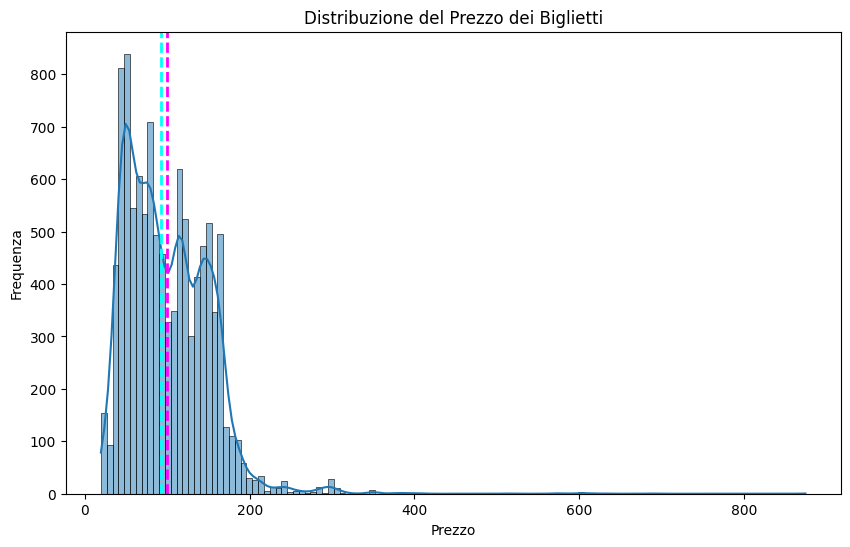

In [3028]:
plt.figure(figsize=(10, 6))
sns.histplot(dataset['Price'], kde=True)

mean_price = dataset['Price'].mean()
median_price = dataset['Price'].median()

plt.axvline(mean_price, color='magenta', linestyle='dashed', linewidth=2, label=f'Media: {mean_price:.2f} €')
plt.axvline(median_price, color='cyan', linestyle='dashed', linewidth=2, label=f'Mediana: {median_price:.2f} €')


plt.title('Distribuzione del Prezzo dei Biglietti')
plt.xlabel('Prezzo')
plt.ylabel('Frequenza')
plt.show()

La distribuzione del prezzo del biglietto è asimmetrica e presenta una coda  verso destra, indicando la presenza di prezzi più elevati in un numero limitato di casi. Questo suggerisce che la maggior parte dei biglietti ha un prezzo relativamente basso, mentre solo pochi biglietti sono venduti a prezzi molto alti.

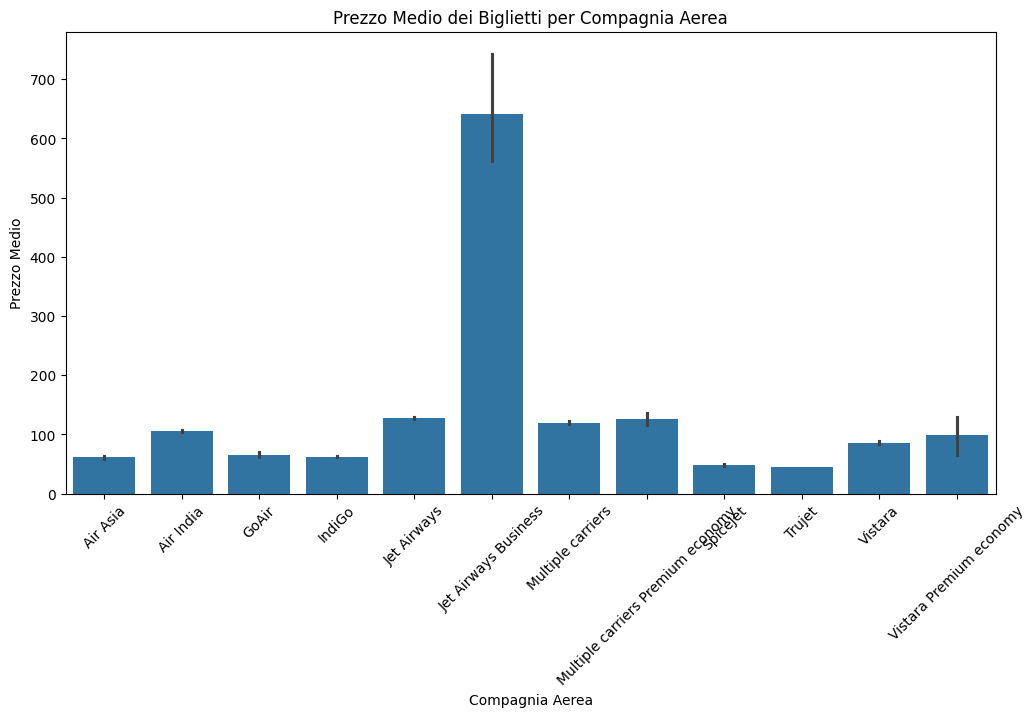

In [3029]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Airline', y='Price', data=dataset)
plt.title('Prezzo Medio dei Biglietti per Compagnia Aerea')
plt.xlabel('Compagnia Aerea')
plt.ylabel('Prezzo Medio')
plt.xticks(rotation=45)
plt.show()

Come possiamo notare la compagnia **Jet Airways Business** ha un prezzo medio significativamente più alto, raggiungendo circa 60,000 rupie, rispetto a tutte le altre compagnie che si aggirano intorno alle 10,000 rupie o meno.

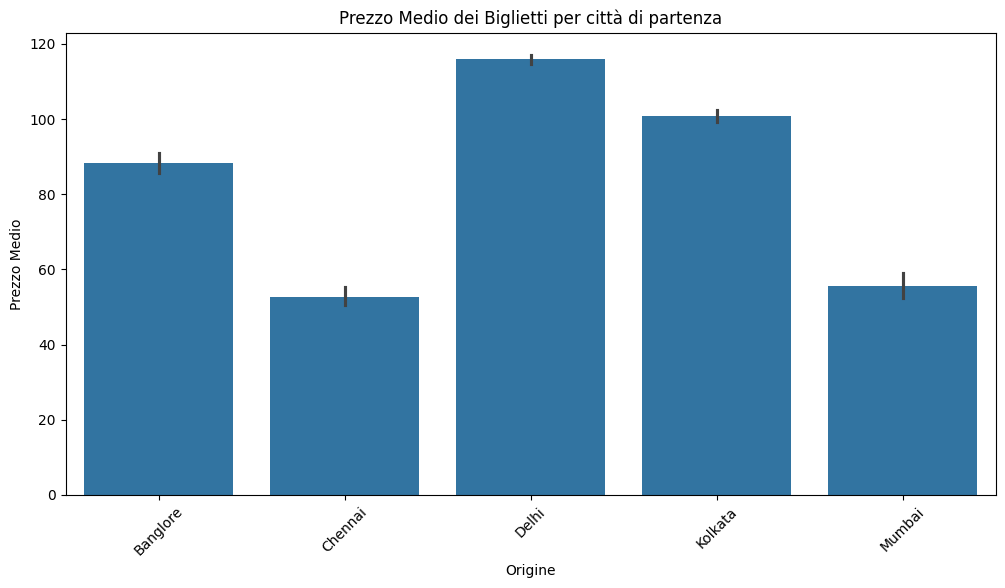

In [3030]:
# Prezzo medio in base alla partenza
plt.figure(figsize=(12, 6))
sns.barplot(x='Source', y='Price', data=dataset)
plt.title('Prezzo Medio dei Biglietti per città di partenza')
plt.xlabel('Origine')
plt.ylabel('Prezzo Medio')
plt.xticks(rotation=45)
plt.show()

Delhi ha i prezzi medi più alti, seguita da Kolkata e Bangalore. Chennai e Mumbai hanno i prezzi medi più bassi, indicativi di rotte più economiche o meno trafficate da queste città.

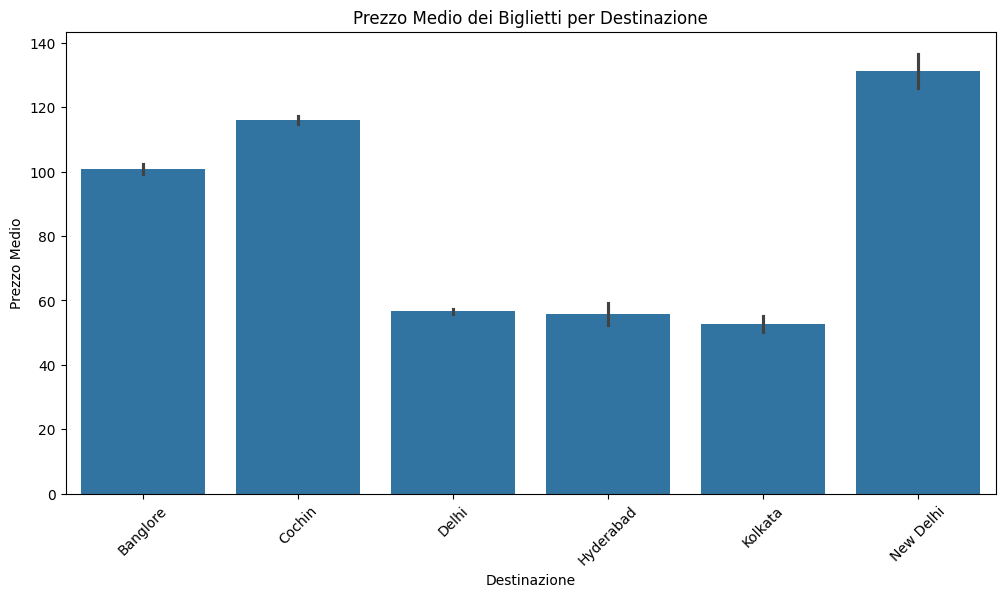

In [3031]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Destination', y='Price', data=dataset)
plt.title('Prezzo Medio dei Biglietti per Destinazione')
plt.xlabel('Destinazione')
plt.ylabel('Prezzo Medio')
plt.xticks(rotation=45)
plt.show()

New Delhi ha il prezzo medio più alto tra le destinazioni, seguita da Cochin e Bangalore. Delhi, Hyderabad e Kolkata hanno prezzi medi significativamente più bassi, suggerendo una maggiore accessibilità o frequenza dei voli verso queste destinazioni

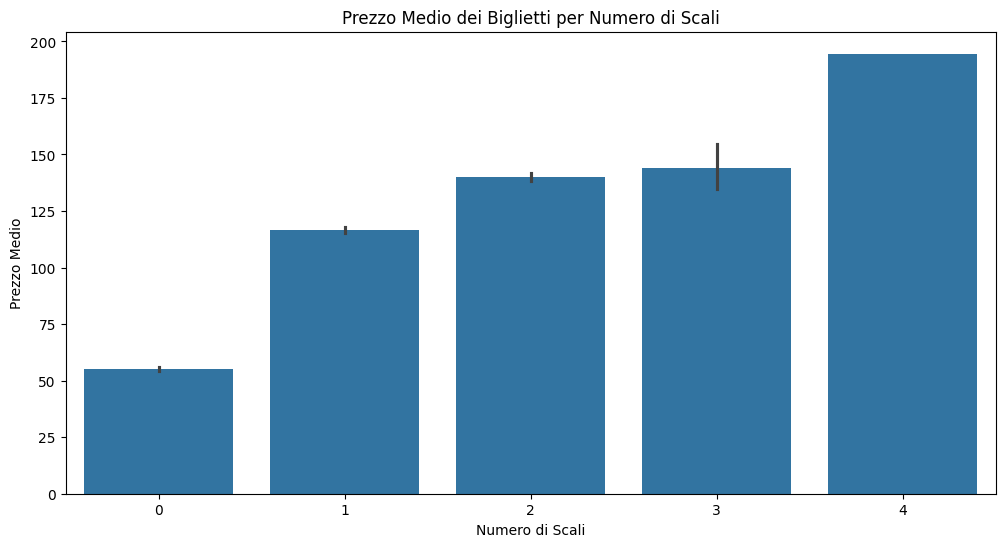

In [3032]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Total_Stops', y='Price', data=dataset)
plt.title('Prezzo Medio dei Biglietti per Numero di Scali')
plt.xlabel('Numero di Scali')
plt.ylabel('Prezzo Medio')
plt.show()

Come possiamo vedere dal grafico i voli diretti sono significativamente più economici rispetto ai voli con scali multipli. La complessità del viaggio influisce notevolmente sui prezzi.

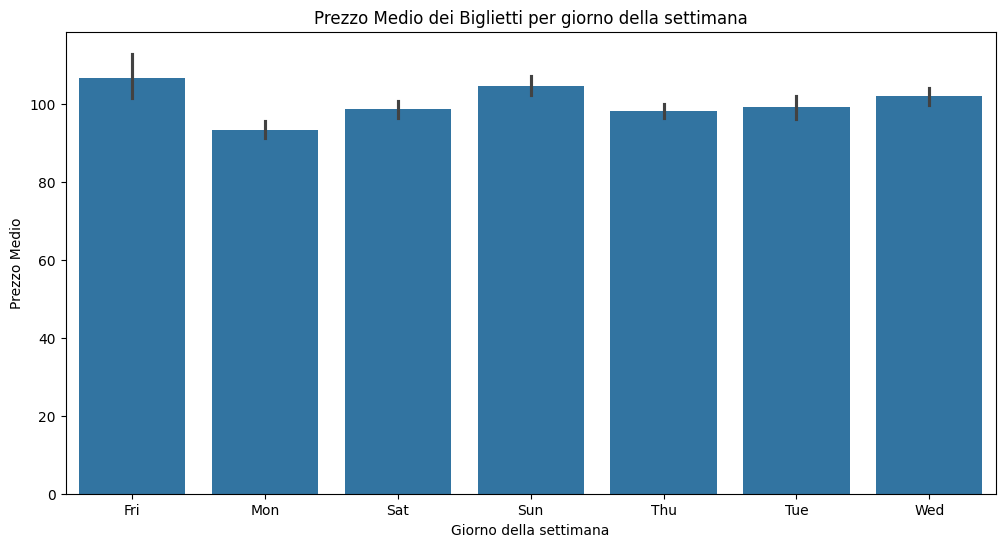

In [3033]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Day_of_Week', y='Price', data=dataset)
plt.title('Prezzo Medio dei Biglietti per giorno della settimana')
plt.xlabel('Giorno della settimana')
plt.ylabel('Prezzo Medio')
plt.show()

I risultati mostrano che ci sono leggere variazioni nei prezzi medi dei biglietti aerei in base al giorno della settimana, con prezzi più alti il venerdì e la domenica e prezzi più bassi ad inizio settimana.

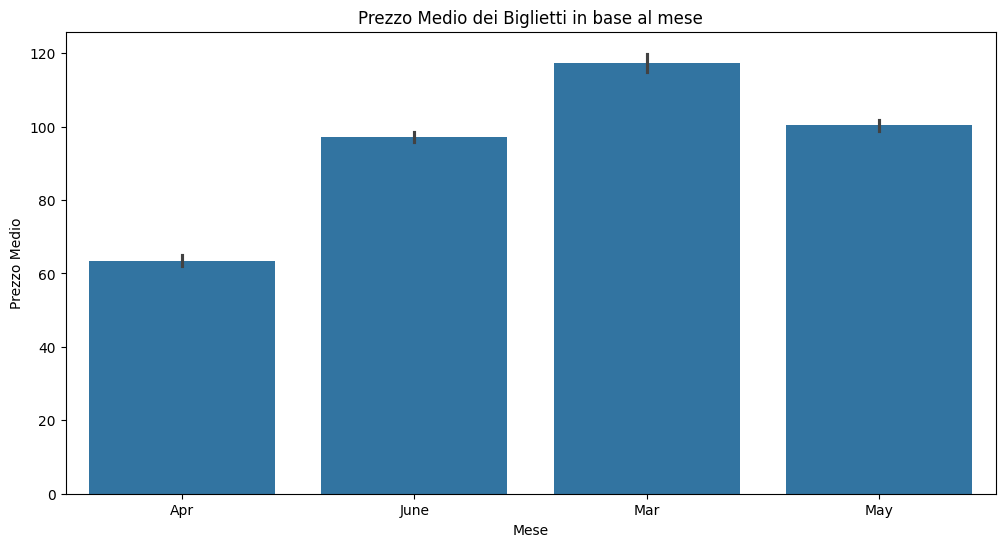

In [3034]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='Price', data=dataset)
plt.title('Prezzo Medio dei Biglietti in base al mese')
plt.xlabel('Mese')
plt.ylabel('Prezzo Medio')
plt.show()

Dal grafico emerge che, nella stagione primaverile, il mese di marzo registra mediamente i prezzi più elevati per i biglietti aerei.

## Preparazione dei dati

Dalla matrice di correlazione vista in precedenza possiamo osservare come ci sia una correlazione forte (74%) tra il numero di scali e la durata in ore del volo. Procediamo quindi ad eliminare la colonna dal dataframe perchè le dipendenze tra le variabili di input renderebbero la regressione instabile

In [3035]:
dataset = dataset.drop(columns=["Duration_hour"])

### Trasformazione delle features categoriche 

Route è una sequenza di città che rappresenta gli scali previsti. Ogni città nella sequenza è un punto di scalo specifico durante il viaggio.

In [3036]:
dataset['Route'].value_counts()

Route
DEL → BOM → COK          2376
BLR → DEL                1552
CCU → BOM → BLR           979
CCU → BLR                 724
BOM → HYD                 621
                         ... 
CCU → IXZ → MAA → BLR       1
BOM → JAI → DEL → HYD       1
BOM → BBI → HYD             1
CCU → RPR → HYD → BLR       1
BLR → BOM → IXC → DEL       1
Name: count, Length: 128, dtype: int64

Procediamo quindi a suddividere le varie tappe della rotta in più variabili.

In [3037]:
dataset['Route1'] = dataset['Route'].str.split('→').str[0]
dataset['Route2'] = dataset['Route'].str.split('→').str[1]
dataset['Route3'] = dataset['Route'].str.split('→').str[2]
dataset['Route4'] = dataset['Route'].str.split('→').str[3]
dataset['Route5'] = dataset['Route'].str.split('→').str[4]

dataset = dataset.drop(columns=["Route"])

In [3038]:
dataset.head(1)

,Airline,Source,Destination,Total_Stops,Price,Day,Month,Day_of_Week,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_minute,Route1,Route2,Route3,Route4,Route5
0,IndiGo,Banglore,New Delhi,0,42.87,24,Mar,Sun,22,20,1,10,50,BLR,DEL,NaN,NaN,NaN


In [3039]:
dataset.isnull().sum()

Airline                0
Source                 0
Destination            0
Total_Stops            0
Price                  0
Day                    0
Month                  0
Day_of_Week            0
Dep_hour               0
Dep_min                0
Arrival_hour           0
Arrival_min            0
Duration_minute        0
Route1                 0
Route2                 0
Route3              3491
Route4              9116
Route5             10636
dtype: int64

In [3040]:
for i in ['Route3', 'Route4', 'Route5'] :
   dataset[i] =  dataset[i].fillna('None')

dataset.isnull().sum()

Airline            0
Source             0
Destination        0
Total_Stops        0
Price              0
Day                0
Month              0
Day_of_Week        0
Dep_hour           0
Dep_min            0
Arrival_hour       0
Arrival_min        0
Duration_minute    0
Route1             0
Route2             0
Route3             0
Route4             0
Route5             0
dtype: int64

Prima di procedere con la regressione è necessario convertire le features categoriche in valori numerici mediante binarizzazione.

In [3041]:
categorical = ["Route1", "Route2", "Route3", "Route4", "Route5", "Source", "Destination", "Day_of_Week", "Airline", "Month"]

In [3042]:
dataset = pd.get_dummies(dataset, columns=categorical, prefix= categorical)
dataset.head(1)

,Total_Stops,Price,Day,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_minute,Route1_BLR,Route1_BOM,...,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Month_Apr,Month_June,Month_Mar,Month_May
0,0,42.87,24,22,20,1,10,50,True,False,...,False,False,False,False,False,False,False,False,True,False


Dall'analisi precedente della variabile Price, abbiamo osservato che essa presenta una distribuzione asimmetrica tendente verso sinistra. Questo tipo di distribuzione potrebbe influenzare le prestazioni del modello di regressione. Per mitigare questo effetto, applichiamo una trasformazione utilizzando la radice quadrata alla variabile Price. Tale trasformazione è stata eseguita nel seguente modo:

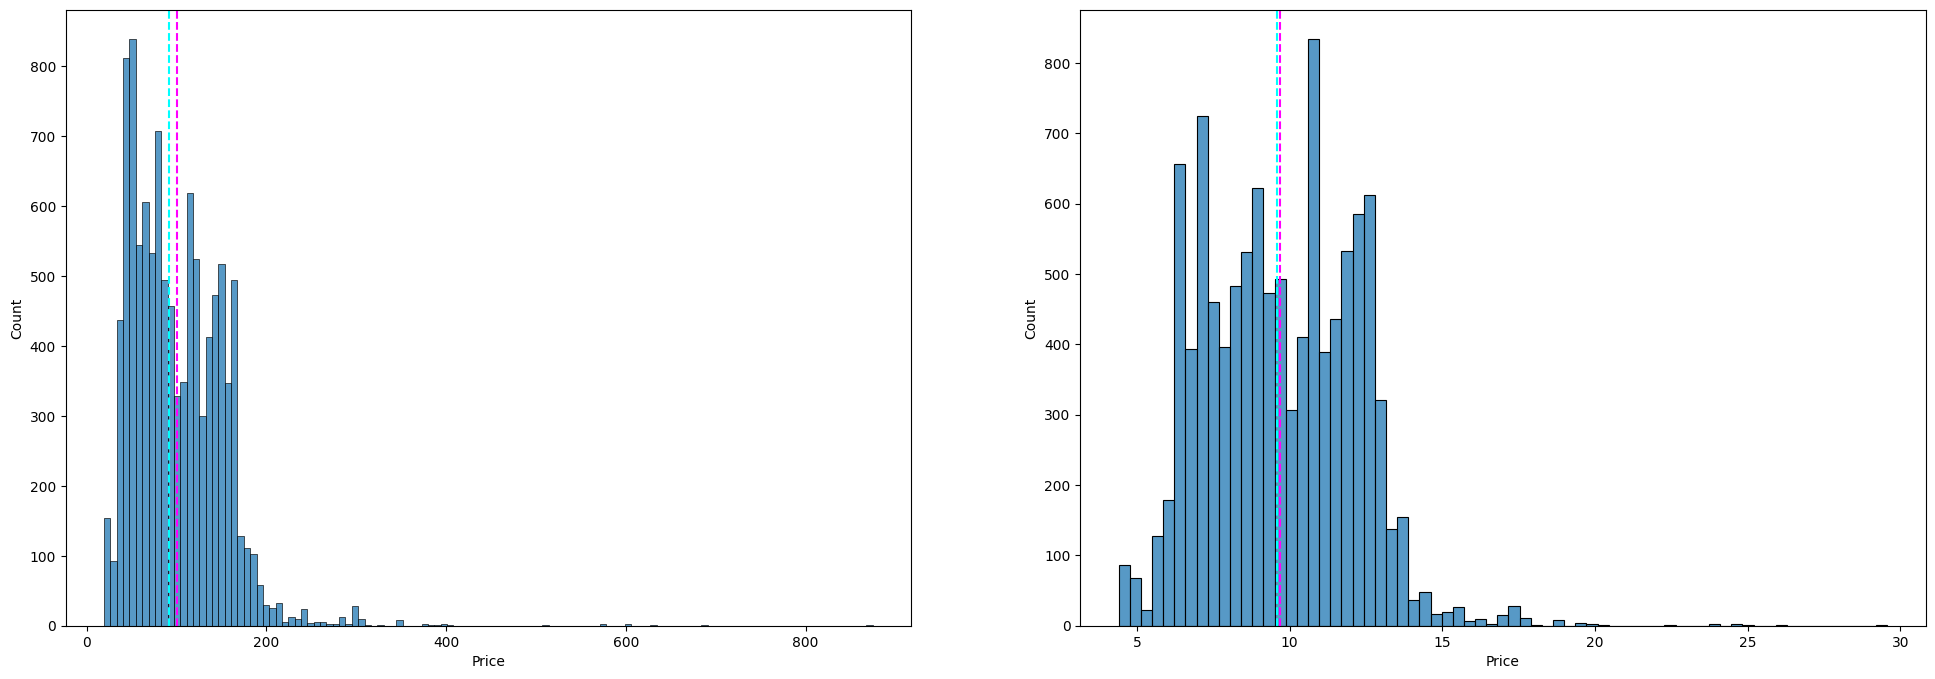

In [3043]:
before = dataset["Price"]
dataset["Price"] = np.sqrt(dataset["Price"])
     

figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(24, 8)

sns.histplot(before, ax=ax1)
ax1.axvline(before.mean(), color='magenta', linestyle='dashed')
ax1.axvline(before.median(), color='cyan', linestyle='dashed')
sns.histplot(dataset["Price"], ax=ax2)
ax2.axvline(dataset["Price"].mean(), color='magenta', linestyle='dashed')
ax2.axvline(dataset["Price"].median(), color='cyan', linestyle='dashed')

Questa trasformazione mira a rendere la distribuzione della variabile Price più simmetrica, migliorando così le prestazioni del modello di regressione.

In [3044]:
from sklearn.model_selection import train_test_split

X = dataset.drop('Price', axis=1)
y = dataset['Price']

In [3045]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)
print(f'Training Set: {X_train.shape[0]} rows\nTest Set: {X_val.shape[0]} rows')


Training Set: 7121 rows
Test Set: 3561 rows


## Addestramento

In [3046]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline

In [3047]:
import warnings
warnings.filterwarnings("ignore")

In [3048]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

In [3049]:
results = [] #ci servirà per raccogliere i risultati dei modelli per poi confrontarli in seguito

### Regressione Lasso


Procediamo con l'implementazione di una pipeline per la regressione Lasso al fine di valutare l'importanza delle feature nel modello. Utilizzeremo la grid search per esplorare diverse combinazioni di iperparametri attraverso una validazione in 5-cross fold validation. Questo ci consentirà di determinare quali feature possono essere considerate meno rilevanti per il modello, ottimizzando così le prestazioni di predizione.

In [3050]:

model = Pipeline([
    ("preprc", StandardScaler()),
    ("linreg", Lasso())
])
grid = {
    "linreg__alpha": [0.1, 1, 3, 5]
}
gs = GridSearchCV(model, param_grid=grid, cv=5, return_train_score=True, error_score='raise')
gs.fit(X_train, y_train)
sel = ["mean_test_score", "mean_train_score", "params"]
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[sel]

,mean_test_score,mean_train_score,params
0,0.698656,0.702891,{'linreg__alpha': 0.1}
1,0.304301,0.304707,{'linreg__alpha': 1}
2,-0.001181,0.000000,{'linreg__alpha': 3}
3,-0.001181,0.000000,{'linreg__alpha': 5}


Sulla base di questi risultati, sembra che alpha = 0.1 produca il mean_test_score più alto tra i valori testati. Quindi, il parametro da scegliere per la regressione Lasso dovrebbe essere alpha = 0.1. 

In [3051]:
model = Pipeline([
    ("preproc", StandardScaler()),
    ("regr", Lasso(alpha=0.1))
])
model.fit(X_train, y_train)
lasso_regression_score = model.score(X_val, y_val)
results.append({"Model": "Lasso Regression", "Best Score": lasso_regression_score})

In [3052]:
lasso = pd.Series(model.named_steps["regr"].coef_, X_train.columns).sort_values(ascending=False)
c = len(lasso[lasso!=0])
print("Features totali: "+ str(len(X_train.columns)))
print("Features estratte: "+ str(c))
lasso[lasso!=0]
     

Features totali: 141
Features estratte: 24


Total_Stops                     0.925074
Airline_Jet Airways             0.479429
Route2_ BOM                     0.311151
Airline_Jet Airways Business    0.260777
Month_Mar                       0.256175
Route2_ DEL                     0.097661
Day_of_Week_Fri                 0.091438
Airline_Multiple carriers       0.088755
Destination_New Delhi           0.053659
Route2_ IXU                     0.020367
Route2_ JDH                     0.016867
Route3_ DEL                     0.001420
Route3_ HYD                    -0.004519
Route2_ MAA                    -0.010500
Day_of_Week_Thu                -0.025366
Airline_GoAir                  -0.038612
Route2_ HYD                    -0.057931
Airline_Air Asia               -0.070333
Month_Apr                      -0.110533
Route3_None                    -0.189225
Day                            -0.192407
Airline_SpiceJet               -0.229215
Route2_ HYD                    -0.250674
Airline_IndiGo                 -0.252914
dtype: float64

IL codice seguente seleziona le feature dal modello Lasso che hanno un coefficiente diverso da zero. Il modello Lasso, essendo un metodo di regressione lineare con regolarizzazione L1, tende a penalizzare i coefficienti delle feature meno rilevanti, portando alcuni di essi a zero.

In [3053]:

keep = lasso[lasso!=0].index.tolist()
l = dataset[keep+["Price"]]

In [3054]:
l.head()

,Total_Stops,Airline_Jet Airways,Route2_ BOM,Airline_Jet Airways Business,Month_Mar,Route2_ DEL,Day_of_Week_Fri,Airline_Multiple carriers,Destination_New Delhi,Route2_ IXU,...,Airline_GoAir,Route2_ HYD,Airline_Air Asia,Month_Apr,Route3_None,Day,Airline_SpiceJet,Route2_ HYD,Airline_IndiGo,Price
0,0,False,False,False,True,False,False,False,True,False,...,False,False,False,False,True,24,False,False,True,6.547519
1,2,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,1,False,False,False,9.180414
2,2,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,9,False,False,False,12.357184
3,1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,12,False,False,True,8.270429
4,1,False,False,False,True,False,True,False,True,False,...,False,False,False,False,False,1,False,False,True,12.096280


In [3055]:
X = l.drop(columns="Price") #aggiorno il valore di X con le features rimanenti 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

### Regressione Ridge

In [3056]:

model = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", Ridge())
])
grid = {
    "linreg__alpha": [0.1, 1, 5, 10]
    }
gs = GridSearchCV(model, param_grid=grid, return_train_score=True, cv=5)
gs.fit(X_train, y_train)
sel = ["mean_test_score", "mean_train_score", "params"]
results.append({"Model": "Ridge Regression", "Best Score": gs.best_score_})
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[sel]



,mean_test_score,mean_train_score,params
3,0.729076,0.732628,{'linreg__alpha': 10}
2,0.729076,0.732630,{'linreg__alpha': 5}
1,0.729074,0.732631,{'linreg__alpha': 1}
0,0.729074,0.732631,{'linreg__alpha': 0.1}


### Regressione Lineare

Addestriamo quindi un modello di regressione lineare sul nostro train set e valutiamone l'accuratezza.

In [3057]:
model = Pipeline([
    ("scale",  StandardScaler(with_mean=False)),
    ("linreg", LinearRegression())
])
model.fit(X_train, y_train)
linear_regression_score = model.score(X_val, y_val)
results.append({"Model": "Linear Regression", "Best Score": linear_regression_score})
  
print(linear_regression_score)

0.7438468056454659


L'accuratezza ottenuta è essenzialmente la stessa nella Regressione Ridge ciò indica che la regolarizzazione ha un impatto trascurabile sui risultati, confermando le nostre aspettative.

### Elastic Net

In [3058]:

from sklearn.linear_model import ElasticNet

model_elasticnet = ElasticNet()
 
pipeline_elasticnet = Pipeline([
    ('scaler', StandardScaler()),  # Standardizzazione dei dati
    ('elasticnet', model_elasticnet)  # Modello ElasticNet
])

param_grid_elasticnet = {
    'elasticnet__alpha': [0.1, 0.5, 1, 3, 5],  # Parametro di regolarizzazione
    'elasticnet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # Rapporto L1 / (L1 + L2)
}

grid_search_elasticnet = GridSearchCV(estimator=pipeline_elasticnet, param_grid=param_grid_elasticnet,  cv=5,  scoring='r2', verbose=1, n_jobs=-1) 

grid_search_elasticnet.fit(X_train, y_train)

# Valutazione dei risultati migliori
best_score = grid_search_elasticnet.best_score_
best_params = grid_search_elasticnet.best_params_

results.append({"Model": "ElasticNet", "Best Score": best_score})
print(f"Miglior score R²: {best_score:.4f}")
print(f"Parametri migliori: {best_params}")


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Miglior score R²: 0.7258
Parametri migliori: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.1}


### Random Forest 

In [3059]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
grid = {
    "max_samples": [0.2,0.3],
    "n_estimators": [10,20,100],
    "max_features": ["sqrt"]
}

gs = GridSearchCV(model, param_grid=grid, cv=5, return_train_score=True, n_jobs=-1)

gs.fit(X_train, y_train)
results.append({"Model": "Random Forest", "Best Score": gs.best_score_})
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False).iloc[:3][sel]


,mean_test_score,mean_train_score,params
5,0.819818,0.855125,"{'max_features': 'sqrt', 'max_samples': 0.3, '..."
2,0.815942,0.845740,"{'max_features': 'sqrt', 'max_samples': 0.2, '..."
4,0.813085,0.850541,"{'max_features': 'sqrt', 'max_samples': 0.3, '..."


In [3060]:
print("R-Squared::{}".format(gs.best_score_))
print("Best Hyperparameters::\n{}".format(gs.best_params_))

R-Squared::0.8198178576368609
Best Hyperparameters::
{'max_features': 'sqrt', 'max_samples': 0.3, 'n_estimators': 100}


### XGBoost

In [3061]:
from xgboost import XGBRegressor

xgbm = XGBRegressor(objective='reg:squarederror', reg_alpha=0.0, reg_lambda=1.0, n_estimators=100)
xgbm.fit(X_train, y_train)
xgbm_score = xgbm.score(X_val, y_val)

results.append({"Model": "XGBoost", "Best Score": xgbm_score})
print(xgbm_score)

0.8492404440867006


### Funzioni kernel

In [3063]:

model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", KernelRidge(kernel="poly"))
])
grid = {
    "regr__degree": range(2,3),
    "regr__alpha": [0.01, 0.1, 1, 10],
}
gs = GridSearchCV(model, grid, cv=5, return_train_score=True)
gs.fit(X_train, y_train)
results.append({"Model": "Kernel Ridge", "Best Score": gs.best_score_})
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[sel]



,mean_test_score,mean_train_score,params
0,0.810040,0.823665,"{'regr__alpha': 0.01, 'regr__degree': 2}"
1,0.810030,0.823289,"{'regr__alpha': 0.1, 'regr__degree': 2}"
2,0.808854,0.820724,"{'regr__alpha': 1, 'regr__degree': 2}"
3,0.800682,0.809235,"{'regr__alpha': 10, 'regr__degree': 2}"


## Valutazione dei modelli migliori

Confrontaimo ora i risulatti ottenuti per ogni modello per poter trovare quello che ha prodotto un risultato migliore

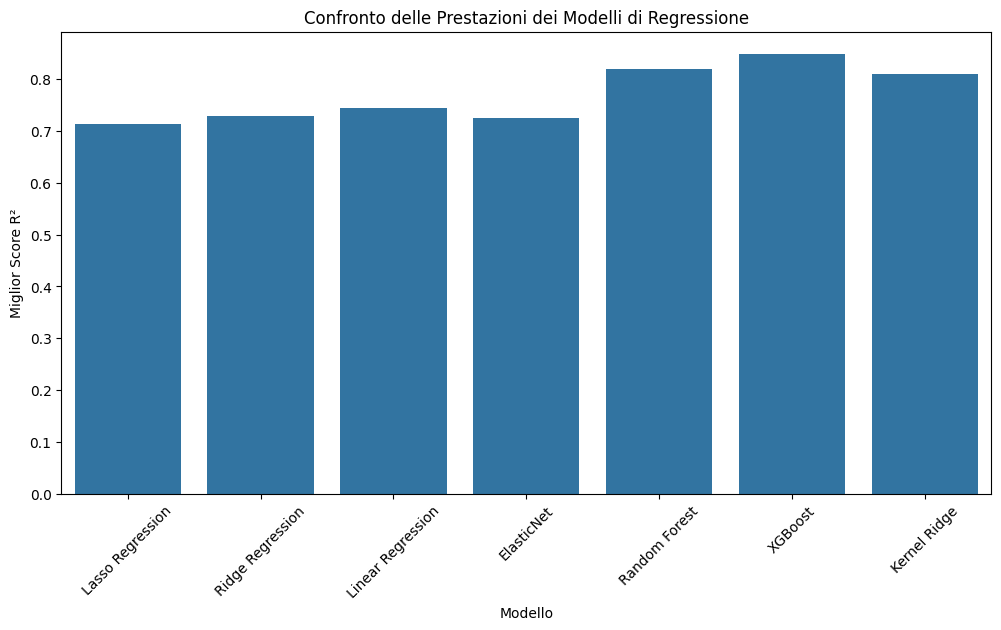

In [3064]:
results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Best Score", data=results_df)
plt.title("Confronto delle Prestazioni dei Modelli di Regressione")
plt.xlabel("Modello")
plt.ylabel("Miglior Score R²")
plt.xticks(rotation=45)
plt.show()

Come possiamo notare dal grafico i modelli di regressione XGBoost , Kernel Ridge e random forest hanno prodotto i risultati migliori

Vediamo ora come si comportano i precedenti modelli su dati mai visti

In [3065]:
def print_eval(X, y, model):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    re = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    print(f"   Mean squared error: {mse:.3f}")
    print(f"       Relative error: {re:.5f}%")
    print(f"R-squared coefficient: {r2:.5f}")

In [3066]:

kernel_model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", KernelRidge(degree=2, alpha=0.1, kernel="poly"))
])

kernel_model.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('regr', KernelRidge(alpha=0.1, degree=2, kernel='poly'))])

In [3067]:

random_forest = RandomForestRegressor(random_state=42)
grid = {
    "max_samples": [0.2, 0.3],
    "n_estimators": [10, 20, 100],
    "max_features": ["sqrt"]
}

gs = GridSearchCV(random_forest, param_grid=grid, cv=5, return_train_score=True, n_jobs=-1)

gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': ['sqrt'], 'max_samples': [0.2, 0.3],
                         'n_estimators': [10, 20, 100]},
             return_train_score=True)

In [3068]:

print("Modello di regressione con kernel polinomiale:")
print_eval(X_val, y_val, kernel_model)

Modello di regressione con kernel polinomiale:
   Mean squared error: 0.979
       Relative error: 0.08014%
R-squared coefficient: 0.83322


In [3069]:
print("Modello di regressione XGBoost:")
print_eval(X_val, y_val, xgbm)

Modello di regressione XGBoost:
   Mean squared error: 0.885
       Relative error: 0.07345%
R-squared coefficient: 0.84924


In [3070]:
print("Modello di regressione Random Forest:")
print_eval(X_val, y_val, gs.best_estimator_)

Modello di regressione Random Forest:
   Mean squared error: 0.923
       Relative error: 0.07514%
R-squared coefficient: 0.84274


## Conclusione

Nel corso di questo progetto, sono stati diversi modelli di regressione per prevedere i prezzi dei biglietti aerei nel periodo primaverile. Attraverso l'analisi e l'implementazione di modelli come Random Forest, XGBoost e Kernel polinomiale, abbiamo valutato le loro performance utilizzando metriche chiave come il coefficiente R-squared e l'errore quadratico medio (MSE).

Dai risultati ottenuti, emerge chiaramente che XGBoost si è dimostrato il modello più efficace per questa specifica previsione. Ha ottenuto il R-squared coefficient più alto (0.84924), indicando una maggiore capacità di spiegare la variazione dei prezzi dei biglietti rispetto alla media. Inoltre, XGBoost ha registrato il MSE più basso (0.885), confermando la sua precisione nel prevedere i prezzi dei biglietti.